In [2]:
import os, io, requests, zipfile
import itertools
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from geopy.distance import great_circle
plt.rcParams['figure.figsize'] = 10,6
import warnings
warnings.filterwarnings("ignore")

In [11]:
df11 = pd.read_csv('data/AIS_2017_12_Zone11.csv')
# df17 = pd.read_csv('data/AIS_2017_12_Zone17.csv')
# df18 = pd.read_csv('data/AIS_2017_12_Zone18.csv')

In [4]:
df11.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,376494000,2017-12-01T00:00:03,30.28963,-116.73522,9.4,158.2,511.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
1,366964020,2017-12-01T00:00:02,32.18853,-118.20766,9.5,22.9,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,367047120,2017-12-01T00:00:01,46.32643,-118.76383,8.4,26.3,24.0,REBEL,NaN,WDC5832,1025.0,under way using engine,24.44,9.1,NaN,NaN
3,367042740,2017-12-01T00:00:14,32.72405,-117.22603,0.0,-49.6,511.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
4,367778000,2017-12-01T00:00:18,33.46477,-118.27461,8.9,192.8,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


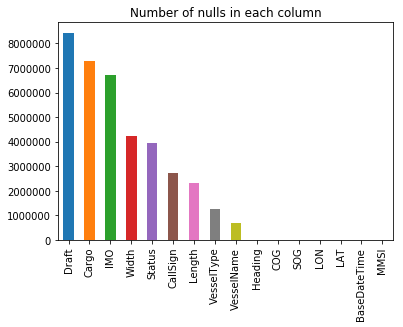

In [5]:
df11.isnull().sum().sort_values(ascending=False).plot(kind='bar');
plt.title("Number of nulls in each column");

In [12]:
df11_time_sorted = df11.sort_values(by='BaseDateTime', ascending=True)

In [13]:
df11_time_sorted.BaseDateTime = pd.to_datetime(df11_time_sorted.BaseDateTime, errors='raise')

In [16]:
df11_time_sorted.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
248,367678850,2017-12-01,33.74392,-118.27475,4.3,-199.8,22.0,LELA FRANCO,IMO9747821,WDI2504,1025.0,under way using engine,24.60,NaN,NaN,NaN
3228,357147000,2017-12-01,31.34268,-117.31180,4.8,-128.6,296.0,SUPREME ACE,IMO9610391,3ETV4,1004.0,under way using engine,199.95,32.20,9.8,70.0
876,303866000,2017-12-01,32.36773,-118.59478,10.0,-138.2,272.0,CG MUNRO,NaN,NMUN,1018.0,under way using engine,NaN,NaN,NaN,NaN
921,366760710,2017-12-01,33.75955,-118.18015,0.0,-68.0,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.60,NaN,NaN
7023,309484000,2017-12-01,31.89289,-117.23647,10.1,33.4,34.0,CARNIVAL INSPIRATION,IMO9087489,C6FM5,1012.0,under way using engine,260.73,36.01,7.8,69.0


In [17]:
#Converting the BasDateTime column to a datetime datatype and adding a date column
df11_time_sorted.BaseDateTime = pd.to_datetime(df11_time_sorted.BaseDateTime, errors='raise')
df11_time_sorted['date'] = df11_time_sorted.BaseDateTime.apply(lambda x: x.date())

In [18]:
interval = 150  #time interval (seconds) 
distance = 24000 #24,000feet = 8000 yards 
neighbor_vessels = pd.DataFrame(columns= df.columns)

# df11 = df.sort_values(by='BaseDateTime', ascending=True) #this is the dataframe to look for matches within
df11_time_sorted_drop = df11_time_sorted.dropna(how='any') 
df11_time_sorted_drop_locked = df11_time_sorted_drop.iloc[:2000] #subsetting to 2000 rows for proof of concept

In [19]:
for i,v in enumerate(df11_time_sorted_drop_locked.BaseDateTime.values): 
    
    df2 = df11_time_sorted_drop_locked.iloc[i+1:,] #removing rows we've already iterated through
    time_min = v - pd.Timedelta(seconds=interval)
    time_max = v + pd.Timedelta(seconds=interval) 
    temp_df = df2[(df2.BaseDateTime > time_min)&(df2.BaseDateTime < time_max)] #makes temp df of datapoints close in time
    
    #getting data into format to use geopy distance calculator
    temp_df['latlon'] = list(zip(temp_df.LAT, temp_df.LON)) 
    temp_df['dist'] = temp_df['latlon'].apply(lambda x: great_circle(temp_df.latlon.values[0], x).feet) #calc distances from row 0
    
    closers = temp_df[(np.abs(temp_df.dist) < distance)] #filter points close in time
    closers = closers.drop_duplicates(subset ='MMSI') #drop duplicates (same boat)
    
    if len(closers) > 1: #if closers includes more than one boat
        neighbor_vessels = neighbor_vessels.append(closers)

In [20]:
neighbor_vessels.head()

,BaseDateTime,COG,CallSign,Cargo,Draft,Heading,IMO,LAT,LON,Length,MMSI,SOG,Status,VesselName,VesselType,Width,date,dist,latlon
5658,2017-12-01 00:00:00,-113.0,WDF7619,79.0,3.0,163.0,IMO9271195,33.72038,-118.27434,48.46,367486370,0.1,moored,NRC QUEST,1011.0,10.19,2017-12-01,0.000000,"(33.72038, -118.27434)"
25585,2017-12-01 00:01:02,-120.7,3EIC8,70.0,14.0,90.0,IMO9302138,33.74408,-118.20240,336.00,372104000,0.1,moored,HANNOVER BRIDGE,1004.0,45.80,2017-12-01,23476.285693,"(33.74408, -118.2024)"
5650,2017-12-01 00:01:09,-132.0,WYZ8282,0.0,6.5,57.0,IMO107376021,33.75363,-118.21277,0.00,365903144,0.3,AIS-SART (active); MOB-AIS; EPIRB-AIS,ELMER M,0.0,0.00,2017-12-01,22271.960676,"(33.75363, -118.21276999999999)"
5654,2017-12-01 00:01:11,101.9,WDD6659,52.0,4.6,102.0,IMO9369239,33.72024,-118.26724,23.80,367175860,8.1,under way using engine,INDEPENDENCE,1025.0,10.36,2017-12-01,2155.001843,"(33.720240000000004, -118.26723999999999)"
4906,2017-12-01 00:01:15,158.5,WDF8246,79.0,2.7,511.0,IMO8978710,33.73501,-118.27099,33.52,367492920,0.0,under way using engine,KENNETH CARL,1010.0,7.90,2017-12-01,5433.140332,"(33.735009999999996, -118.27099)"


In [21]:
df11_time_sorted.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,date
248,367678850,2017-12-01,33.74392,-118.27475,4.3,-199.8,22.0,LELA FRANCO,IMO9747821,WDI2504,1025.0,under way using engine,24.60,NaN,NaN,NaN,2017-12-01
3228,357147000,2017-12-01,31.34268,-117.31180,4.8,-128.6,296.0,SUPREME ACE,IMO9610391,3ETV4,1004.0,under way using engine,199.95,32.20,9.8,70.0,2017-12-01
876,303866000,2017-12-01,32.36773,-118.59478,10.0,-138.2,272.0,CG MUNRO,NaN,NMUN,1018.0,under way using engine,NaN,NaN,NaN,NaN,2017-12-01
921,366760710,2017-12-01,33.75955,-118.18015,0.0,-68.0,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.60,NaN,NaN,2017-12-01
7023,309484000,2017-12-01,31.89289,-117.23647,10.1,33.4,34.0,CARNIVAL INSPIRATION,IMO9087489,C6FM5,1012.0,under way using engine,260.73,36.01,7.8,69.0,2017-12-01


In [28]:
df11_time_sorted[(df11_time_sorted.LAT > lat_min)&(df11_time_sorted.LAT < lat_max)]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
248,367678850,2017-12-01T00:00:00,33.74392,-118.27475,4.3,-199.8,22.0,LELA FRANCO,IMO9747821,WDI2504,1025.0,under way using engine,24.60,NaN,NaN,NaN
3228,357147000,2017-12-01T00:00:00,31.34268,-117.31180,4.8,-128.6,296.0,SUPREME ACE,IMO9610391,3ETV4,1004.0,under way using engine,199.95,32.20,9.8,70.0
876,303866000,2017-12-01T00:00:00,32.36773,-118.59478,10.0,-138.2,272.0,CG MUNRO,NaN,NMUN,1018.0,under way using engine,NaN,NaN,NaN,NaN
921,366760710,2017-12-01T00:00:00,33.75955,-118.18015,0.0,-68.0,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.60,NaN,NaN
7023,309484000,2017-12-01T00:00:00,31.89289,-117.23647,10.1,33.4,34.0,CARNIVAL INSPIRATION,IMO9087489,C6FM5,1012.0,under way using engine,260.73,36.01,7.8,69.0
60,366678000,2017-12-01T00:00:00,33.42921,-117.78058,10.9,-79.9,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2826,366979360,2017-12-01T00:00:00,33.90826,-118.45014,0.7,37.7,511.0,ARTHUR FOSS,IMO8219011,WRB5693,1025.0,under way using engine,32.31,11.60,NaN,NaN
875,341632000,2017-12-01T00:00:00,33.36170,-119.22185,0.5,115.7,123.0,GEO EXPLORER,IMO6700391,V4YI,1010.0,restricted maneuverability,74.83,12.40,NaN,NaN
1381,538002278,2017-12-01T00:00:00,33.69676,-118.12183,0.0,138.8,266.0,SEAWAYS GOLDMAR,IMO9239628,V7HO8,1024.0,at anchor,228.00,32.23,NaN,NaN
105,367076360,2017-12-01T00:00:00,33.73462,-118.24783,0.1,178.2,511.0,CAMPBELL FOSS,IMO9369198,WDC7754,1025.0,under way using engine,23.77,10.36,NaN,NaN


In [29]:
df11_time_sorted.shape

(10398527, 16)

In [34]:
def max_min_lat_lon(df):
    data = {
        'lat_max': df['LAT'].max(),
        'lat_min': df['LAT'].min(),
        'lon_max': df['LON'].max(),
        'lon_min': df['LON'].min()
    }
    return data

# lat_interval =
# lon_interval =
borders = max_min_lat_lon(df11)
# print(borders)
border_min_gps = (borders['lat_min'], borders['lon_min'])
border_max_lat = (borders['lat_max'], borders['lon_min'])
border_max_lon = (borders['lat_min'], borders['lon_max'])

lat_distance = great_circle(border_min_gps, border_max_lat).feet / 3
lon_distance = great_circle(border_min_gps, border_max_lon).feet / 3

lat_distance_num_intervals = lon_distance / 4000
lon_distance_num_intervals = lat_distance / 4000

lat_distance_intervals = np.linspace(borders['lat_min'], borders['lat_max'], lat_distance_num_intervals)
lon_distance_intervals = np.linspace(borders['lon_min'], borders['lon_max'], lon_distance_num_intervals)

# print(lat_distance_intervals, len(lat_distance_intervals))
# print(lon_distance_intervals, len(lon_distance_intervals))

i=0
for temp_box_lat in lat_distance_intervals:
    for temp_box_lon in lon_distance_intervals:
        i=i+1
print(i)

471867


In [32]:
df11_time_sorted['BaseDateTime'].max
df11_time_sorted['BaseDateTime'].min

<bound method Series.min of 248         2017-12-01T00:00:00
3228        2017-12-01T00:00:00
876         2017-12-01T00:00:00
921         2017-12-01T00:00:00
7023        2017-12-01T00:00:00
60          2017-12-01T00:00:00
2826        2017-12-01T00:00:00
875         2017-12-01T00:00:00
1381        2017-12-01T00:00:00
105         2017-12-01T00:00:00
2609        2017-12-01T00:00:00
2436        2017-12-01T00:00:00
2131        2017-12-01T00:00:00
2196        2017-12-01T00:00:00
2348        2017-12-01T00:00:00
5658        2017-12-01T00:00:00
749         2017-12-01T00:00:00
984         2017-12-01T00:00:00
722         2017-12-01T00:00:00
539         2017-12-01T00:00:00
489         2017-12-01T00:00:00
2           2017-12-01T00:00:01
1971        2017-12-01T00:00:01
1970        2017-12-01T00:00:01
2499        2017-12-01T00:00:01
1802        2017-12-01T00:00:01
1801        2017-12-01T00:00:01
1713        2017-12-01T00:00:01
376         2017-12-01T00:00:01
1584        2017-12-01T00:00:01
            

In [35]:
df11[(df11.MMSI == 357147000)|(df11.MMSI == 366760710)]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
390,366760710,2017-12-01T00:02:19,33.75954,-118.18004,0.8,79.2,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
561,366760710,2017-12-01T00:07:10,33.75991,-118.17875,1.2,120.2,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
863,366760710,2017-12-01T00:09:30,33.75851,-118.17660,6.2,130.8,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
867,366760710,2017-12-01T00:10:41,33.75707,-118.17474,6.6,134.9,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
896,366760710,2017-12-01T00:05:59,33.75967,-118.17847,1.6,90.4,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
921,366760710,2017-12-01T00:00:00,33.75955,-118.18015,0.0,-68.0,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
928,366760710,2017-12-01T00:01:11,33.75956,-118.18017,0.0,-62.7,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
1434,366760710,2017-12-01T00:13:00,33.75392,-118.17126,6.6,141.8,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
2068,366760710,2017-12-01T00:04:40,33.75974,-118.17915,1.7,88.8,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN
2109,366760710,2017-12-01T00:08:20,33.75955,-118.17815,3.1,133.6,511.0,REDONDO,NaN,WCD3906,1012.0,under way using engine,18.78,7.6,NaN,NaN


In [40]:
ships = df11['MMSI'].tolist()

In [22]:
df11_time_sorted['Date'] = df11_time_sorted.BaseDateTime.apply(lambda x: x.date())

In [ ]:
df11

In [17]:
import datetime
from datetime import timedelta

In [19]:
def max_min_lat_lon(df):
    data = {
        'lat_max': df['LAT'].max(),
        'lat_min': df['LAT'].min(),
        'lon_max': df['LON'].max(),
        'lon_min': df['LON'].min()
    }
    return data

In [24]:
date_min = df11_time_sorted.BaseDateTime.min().date()  # start date
date_max = df11_time_sorted.BaseDateTime.max().date()  # end date

delta = date_max - date_min         # timedelta

dates=[]
for i in range(delta.days + 1):
    dates.append(date_min + datetime.timedelta(i))
date = dates[0]

print(date)
df11_date = df11_time_sorted[(df11_time_sorted.Date >= date) & (df11_time_sorted.Date < date+datetime.timedelta(1))]
print(df11_date.Date.max(), df11_date.Date.min())

borders = max_min_lat_lon(df11_date)
print(borders)
border_min_gps = (borders['lat_min'], borders['lon_min'])
border_max_lat = (borders['lat_max'], borders['lon_min'])
border_max_lon = (borders['lat_min'], borders['lon_max'])

lat_distance = great_circle(border_min_gps, border_max_lat).feet / 3
lon_distance = great_circle(border_min_gps, border_max_lon).feet / 3

lat_distance_num_intervals = lon_distance / 4000
lon_distance_num_intervals = lat_distance / 4000

lat_distance_intervals = np.linspace(borders['lat_min'], borders['lat_max'], lat_distance_num_intervals)
lon_distance_intervals = np.linspace(borders['lon_min'], borders['lon_max'], lon_distance_num_intervals)

print(lat_distance_intervals, len(lat_distance_intervals))
print(lon_distance_intervals, len(lon_distance_intervals))

ships = df11_date.MMSI.tolist()

2017-12-01
2017-12-01 2017-12-01
{'lat_max': 46.7021, 'lat_min': 22.749129999999997, 'lon_max': -114.15671, 'lon_min': -119.99998000000001}
[22.74913    22.89698784 23.04484568 23.19270352 23.34056136 23.4884192
 23.63627704 23.78413488 23.93199272 24.07985056 24.2277084  24.37556623
 24.52342407 24.67128191 24.81913975 24.96699759 25.11485543 25.26271327
 25.41057111 25.55842895 25.70628679 25.85414463 26.00200247 26.14986031
 26.29771815 26.44557599 26.59343383 26.74129167 26.88914951 27.03700735
 27.18486519 27.33272302 27.48058086 27.6284387  27.77629654 27.92415438
 28.07201222 28.21987006 28.3677279  28.51558574 28.66344358 28.81130142
 28.95915926 29.1070171  29.25487494 29.40273278 29.55059062 29.69844846
 29.8463063  29.99416414 30.14202198 30.28987981 30.43773765 30.58559549
 30.73345333 30.88131117 31.02916901 31.17702685 31.32488469 31.47274253
 31.62060037 31.76845821 31.91631605 32.06417389 32.21203173 32.35988957
 32.50774741 32.65560525 32.80346309 32.95132093 33.099178

In [86]:
d1=datetime.date(2017,12,1)

In [88]:
d1+timedelta(1)

datetime.date(2017, 12, 2)

In [ ]:
>>> from datetime import datetime
>>> from collections import namedtuple
>>> Range = namedtuple('Range', ['start', 'end'])

>>> r1 = Range(start=datetime.datetime(2012, 1, 15), end=datetime.datetime(2012, 5, 10))
>>> r2 = Range(start=datetime.datetime(2012, 3, 20), end=datetime.datetime(2012, 9, 15))
>>> latest_start = max(r1.start, r2.start)
>>> earliest_end = min(r1.end, r2.end)
>>> delta = (earliest_end - latest_start).days + 1
>>> overlap = max(0, delta)
>>> overlap

In [32]:
from collections import namedtuple
Range = namedtuple('Range', ['start', 'end'])
r1 = Range(start=datetime.datetime(2017, 12, 1, 0, 10, 0), end=datetime.datetime(2017, 12, 1, 1, 10, 0))
r2 = Range(start=datetime.datetime(2017, 12, 1, 0, 30, 0), end=datetime.datetime(2017, 12, 1, 1, 40, 0))
time_overlap(r1, r2)
def time_overlap(r1, r2):
    latest_start = max(r1.start, r2.start)
    earliest_end = min(r1.end, r2.end)
#     time_delta = (earliest_end - latest_start)
#     overlap = max(0, delta)
#     print(overlap)

AttributeError: 'datetime.timedelta' object has no attribute 'minutes'

In [44]:
ships = list(set(df11_date.MMSI.tolist()))

In [46]:
ships.sort()

In [47]:
ships

[122292919,
 201216315,
 207829990,
 207829991,
 209890000,
 211367460,
 218826000,
 219602000,
 219617000,
 220580000,
 224718000,
 229726000,
 235072407,
 235076283,
 235077448,
 235099968,
 236000990,
 239861000,
 241528000,
 244128000,
 249778000,
 256930000,
 265549870,
 269110210,
 303294000,
 303422000,
 303849000,
 303865936,
 303866000,
 306970007,
 309484000,
 309509000,
 309933000,
 310409000,
 310567000,
 311000111,
 311000112,
 311000438,
 311000467,
 316002721,
 316006264,
 316021453,
 316033336,
 319063100,
 319086500,
 319102700,
 319122900,
 319160000,
 319264000,
 319266000,
 319421000,
 319630000,
 319738000,
 319824000,
 319904000,
 338002098,
 338003172,
 338004941,
 338022000,
 338032837,
 338034287,
 338035036,
 338037842,
 338037843,
 338041439,
 338045551,
 338050903,
 338054125,
 338058215,
 338067800,
 338069896,
 338070397,
 338070516,
 338071811,
 338075091,
 338076155,
 338078421,
 338080883,
 338084479,
 338086858,
 338087117,
 338088774,
 338092107,
 338

In [76]:
from itertools import combinations
s = [122292919,
 201216315,
 207829990,
 207829991,
 209890000]

In [77]:
ship_combos_checked = set()
if s is not None and len(s) > 1:
    # print('Starting box', temp_box_lat, temp_box_lon)
    # print('Count ships:', len(ships))
    # Create all combinations of ships that haven't been checked yet
    ship_combinations = set(list(combinations(s, 2)))  # 2 for pairs, 3 for triplets, etc
    ship_combinations = ship_combinations - ship_combos_checked
    for combo in ship_combinations:
        # check time in here
        # Check distance between ships
        ship_combos_checked.add(combo)

In [78]:
ship_combos_checked

{(122292919, 201216315),
 (122292919, 207829990),
 (122292919, 207829991),
 (122292919, 209890000),
 (201216315, 207829990),
 (201216315, 207829991),
 (201216315, 209890000),
 (207829990, 207829991),
 (207829990, 209890000),
 (207829991, 209890000)}

In [79]:
s = [122292919,
 201216315,
 207829990,
 207829991,
 209890000,
 236000990]

In [80]:
if s is not None and len(s) > 1:
    # print('Starting box', temp_box_lat, temp_box_lon)
    # print('Count ships:', len(ships))
    # Create all combinations of ships that haven't been checked yet
    ship_combinations = set(list(combinations(s, 2)))  # 2 for pairs, 3 for triplets, etc
    ship_combinations = ship_combinations - ship_combos_checked
    for combo in ship_combinations:
        # check time in here
        # Check distance between ships
        print(combo)
        ship_combos_checked.add(combo)

(122292919, 236000990)
(209890000, 236000990)
(207829990, 236000990)
(207829991, 236000990)
(201216315, 236000990)


In [84]:
d=set()
for f in d:
    print(f)

In [86]:
n = datetime.datetime.now()

In [87]:
m = datetime.datetime.now()

In [89]:
delt = m-n

In [92]:
delt.seconds / 60

0.9666666666666667